##Word2Vec from Scratch

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [1]:
corpus = ["apple orange fruit", "banana apple fruit", "banana orange apple",
                 "dog cat animal", "cat pig dog", "pig dog animal","animal cat pig", "iphone apple tech", "windows tech mobile apple", "apple tech windows", "mobile iphone apple"]

In [50]:
# corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
#                  "dog cat animal", "cat animal dog", "cat dog animal"]

In [51]:
#split by spaces
corpus = [word.split(" ") for word in corpus]
corpus

[['apple', 'orange', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'orange', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'pig', 'dog'],
 ['pig', 'dog', 'animal'],
 ['animal', 'cat', 'pig'],
 ['iphone', 'apple', 'tech'],
 ['windows', 'tech', 'mobile', 'apple'],
 ['apple', 'tech', 'windows'],
 ['mobile', 'iphone', 'apple']]

In [52]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['cat',
 'tech',
 'banana',
 'iphone',
 'fruit',
 'dog',
 'pig',
 'mobile',
 'orange',
 'windows',
 'animal',
 'apple']

In [53]:
#word to index
word2index = {w: i for i, w in enumerate(vocab)}
word2index["<UNK>"] = len(word2index)
print(word2index,len(word2index))

{'cat': 0, 'tech': 1, 'banana': 2, 'iphone': 3, 'fruit': 4, 'dog': 5, 'pig': 6, 'mobile': 7, 'orange': 8, 'windows': 9, 'animal': 10, 'apple': 11, '<UNK>': 12} 13


In [54]:
#index to word
index2word = {v:k for k, v in word2index.items()}
index2word

{0: 'cat',
 1: 'tech',
 2: 'banana',
 3: 'iphone',
 4: 'fruit',
 5: 'dog',
 6: 'pig',
 7: 'mobile',
 8: 'orange',
 9: 'windows',
 10: 'animal',
 11: 'apple',
 12: '<UNK>'}

In [55]:
corpus

[['apple', 'orange', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'orange', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'pig', 'dog'],
 ['pig', 'dog', 'animal'],
 ['animal', 'cat', 'pig'],
 ['iphone', 'apple', 'tech'],
 ['windows', 'tech', 'mobile', 'apple'],
 ['apple', 'tech', 'windows'],
 ['mobile', 'iphone', 'apple']]

##Preparing Training Data


In [56]:
def random_batch(batch_size, word_sequence):

    # Make skip gram of one size window
    skip_grams = []
    # loop each word sequence
    # we starts from 1 because 0 has no context
    # we stop at second last for the same reason
    for sent in corpus:
        for i in range(1, len(sent) - 1):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 1]], word2index[sent[i + 1]]]
            for w in context:
                skip_grams.append([target, w])
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement

    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3

    return np.array(random_inputs), np.array(random_labels)

In [57]:
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

Input:  [[0]
 [1]]
Target:  [[5]
 [7]]


## Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [58]:
class Skipgram(nn.Module):

    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)

    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]

        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)

        return nll # negative log likelihood

In [59]:
##Create Skipgram model
voc_size= len(vocab)
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = Skipgram(voc_size, embedding_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 12])

In [61]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [67]:
import time

# Training
num_epochs = 7000
for epoch in range(num_epochs):

    start = time.time()

    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)

    loss.backward()
    optimizer.step()

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 1.605965 | time: 0m 0s
Epoch: 2000 | cost: 1.764609 | time: 0m 0s
Epoch: 3000 | cost: 1.440331 | time: 0m 0s
Epoch: 4000 | cost: 1.436439 | time: 0m 0s
Epoch: 5000 | cost: 2.462426 | time: 0m 0s
Epoch: 6000 | cost: 1.308811 | time: 0m 0s
Epoch: 7000 | cost: 1.482688 | time: 0m 0s


In [68]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

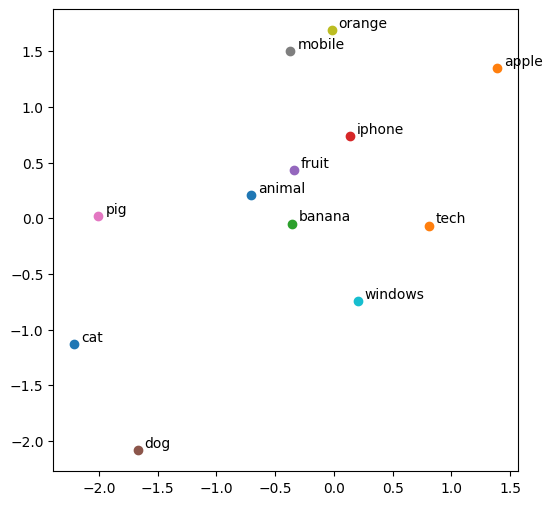

In [69]:
plt.figure(figsize=(6,6))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [65]:
iphone = get_embed("iphone")
banana = get_embed("banana")
apple = get_embed("apple")
print(apple)
print(banana)
print(iphone)

(0.7780648469924927, 0.823800802230835)
(-0.3262425363063812, -0.06221267580986023)
(-0.9066522121429443, 0.33789142966270447)


In [66]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

print(f"iphone vs. apple: ",        cos_sim(iphone, apple))
print(f"banana vs. apple: ",       cos_sim(apple, banana))
print(f"iphone vs. banana: ",          cos_sim(iphone, banana))
print(f"apple vs. apple: ",       cos_sim(apple, apple))

iphone vs. apple:  -0.3895277762854955
banana vs. apple:  -0.8106646900503277
iphone vs. banana:  0.85504037116298
apple vs. apple:  1.0
